# Actor-Critic Method

In [1]:
from __future__ import print_function

import numpy as np
import random
import matplotlib.pyplot as plt
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

import pygame
import Maze_Solver as maze_solver
from Maze_Solver import MazeSolver, MazeSolverEnv
import Maze_Generator as maze_generator

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# cuda가 설치되어 있다면 cuda를 사용하고 아니라면 cpu만을 사용한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

![](https://firebasestorage.googleapis.com/v0/b/aing-biology.appspot.com/o/sutton_barto_reinforcement_learning%2Fchapter13%2F01.PNG?alt=media&token=7dbd1717-7691-44fc-9375-c86fe3d04e7a)

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, inputs, outputs):
        super(ActorCritic, self).__init__()
        
        # for Actor
        self.actor_fc1 = nn.Linear(inputs, 256)
        self.critic_fc1 = nn.Linear(inputs, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, inputs)
        self.fc4 = nn.Linear(inputs, outputs)
        self.actor_fc5 = nn.Linear(256, outputs)
        self.critic_fc5 = nn.Linear(256, 1)
        self.bn1 = nn.BatchNorm1d(256) # 4 actions
        self.bn2 = nn.BatchNorm1d(inputs)
        self.bn3 = nn.BatchNorm1d(outputs)
        self.tanh = nn.Tanh()
        self.LeakyReLU = nn.LeakyReLU(0.1)
        self.head = nn.Softmax(dim=0)
        
        # torch.log makes nan(not a number) error so we have to add some small number in log function
        self.ups=1e-7

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        state = x.to(device)
        probs = F.relu(self.actor_fc1(state))
        probs = self.head(self.actor_fc5(probs))
        '''
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        '''
        
        value = F.relu(self.critic_fc1(state))
        value = self.critic_fc5(value)
        '''
        v = self.fc2(v)
        v = self.fc3(v)
        v = self.fc4(v)
        '''
        return value, probs
    
    def pi(self, s, a):
        s = torch.Tensor(s)
        #s = torch.unsqueeze(s, 0)
        _, probs = self.forward(s)
        probs = torch.squeeze(probs, 0)
        return probs[a]
    
    def get_action(self, state):
        state = torch.tensor(state)
        #state = torch.unsqueeze(state, 0)
        _, probs = self.forward(state)
        probs = torch.squeeze(probs, 0)
        
        action = probs.multinomial(num_samples=1)
        action = action.data
        
        action = action[0]
        return action
    
    def epsilon_greedy_action(self, state, epsilon = 0.1):
        state = torch.tensor(state)
        state = torch.unsqueeze(state, 0)
        _, probs = self.forward(state)
        
        probs = torch.squeeze(probs, 0)
        
        if random.random() > epsilon:
            action = torch.tensor([torch.argmax(probs)])
        else:
            action = torch.rand(probs.shape).multinomial(num_samples=1)
        
        action = action.data
        action = action[0]
        return action
    
    def value(self, s):
        s = torch.tensor(s)
        s = torch.unsqueeze(s, 0)
        value, _ = self.forward(s)
        value = torch.squeeze(value, 0)
        value = value[0]
        
        return value
    
def update_weight(optimizer, states, actions, rewards, last_state, entropy_term = 0):
    # compute Q values
    Qval = actor_critic.value(last_state)
    loss = 0
    
    for s_t, a_t, r_tt in reversed(list(zip(states, actions, rewards))):
        log_prob = torch.log(actor_critic.pi(s_t, a_t))
        value = actor_critic.value(s_t)
        Qval = r_tt + GAMMA * torch.clone(Qval)
        
        advantage = Qval - value

        actor_loss = (-log_prob * advantage)
        critic_loss = 0.5 * advantage.pow(2)
        loss += actor_loss + critic_loss + 0.001 * entropy_term

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        

Episode 10 return 17.0
Episode 20 return 30.0
Episode 30 return 11.0
Episode 40 return 10.0
Episode 50 return 29.0
Episode 60 return 19.0
Episode 70 return 28.0
Episode 80 return 17.0
Episode 90 return 21.0
Episode 100 return 32.0
Episode 110 return 70.0
Episode 120 return 61.0
Episode 130 return 17.0
Episode 140 return 26.0
Episode 150 return 36.0
Episode 160 return 32.0
Episode 170 return 42.0
Episode 180 return 14.0
Episode 190 return 19.0
Episode 200 return 70.0
Episode 210 return 20.0
Episode 220 return 19.0
Episode 230 return 32.0
Episode 240 return 40.0
Episode 250 return 21.0
Episode 260 return 15.0
Episode 270 return 54.0
Episode 280 return 57.0
Episode 290 return 64.0
Episode 300 return 51.0
Episode 310 return 36.0
Episode 320 return 37.0
Episode 330 return 27.0
Episode 340 return 168.0
Episode 350 return 89.0
Episode 360 return 63.0
Episode 370 return 16.0
Episode 380 return 181.0
Episode 390 return 72.0
Episode 400 return 103.0
Episode 410 return 26.0
Episode 420 return 136

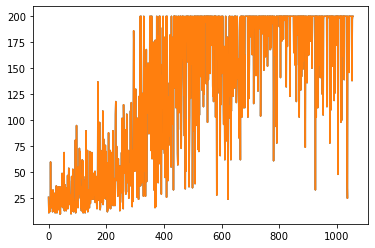

In [5]:
MAX_EPISODES = 3000
MAX_TIMESTEPS = 1000

ALPHA = 3e-4 # learning rate
GAMMA = 0.99 # step-size

#env = MazeSolverEnv()
env = gym.make('CartPole-v0')

#num_actions = env.num_action
num_actions = env.action_space.n
#num_states = 365
num_states = env.observation_space.shape[0]

actor_critic = ActorCritic(num_states, num_actions).to(device)

optimizer = optim.Adam(actor_critic.parameters(), lr=ALPHA)

try:
    returns = []
    
    for i_episode in range(MAX_EPISODES):

        #state = env.init_obs
        state = env.reset()
        init_state = state
        
        done = False
        
        states = []
        actions = []
        rewards = []   # no reward at t = 0

        #while not done:
        for timesteps in range(MAX_TIMESTEPS):
            
            states.append(state)
            
            action = actor_critic.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(action.tolist())
            rewards.append(reward)

            if done or timesteps == MAX_TIMESTEPS-1:
                last_state = state
                break
        
        update_weight(optimizer, states, actions, rewards, last_state)
        
        '''
        #====================================================================================================
        #to see the change of the weights====================================================================
        #====================================================================================================
        print("=========================================================================================")
        print("actor_critic.actor_fc1.weight : {}".format(actor_critic.actor_fc1.weight))
        print("actor_critic.critic_fc2.weight : {}".format(actor_critic.critic_fc1.weight))
        #====================================================================================================
        '''

        if (i_episode + 1) % 500 == 0:
            print("Episode {} return {}".format(i_episode + 1, sum(rewards)))
            torch.save(actor_critic, './saved_models/actor_critic' + str(i_episode + 1) + '.pt')
        elif (i_episode + 1) % 10 == 0:
            print("Episode {} return {}".format(i_episode + 1, sum(rewards)))
            
        returns.append(sum(rewards))
        #env.reset_player(exploring_starts = False)

except KeyboardInterrupt:
    plt.plot(range(len(returns)), returns)
finally:
    plt.plot(range(len(returns)), returns)

env.close()
